# Spatial Modes

In [1]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,ifft,fft2,fftshift,ifftshift
fact = np.math.factorial

from scipy.special import j0, j1
from scipy.special import jn_zeros
from scipy.special import eval_hermite as Hermite
from scipy.special import eval_genlaguerre as Laguerre

from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from simfuncs import soln_to_csv,soln_from_csv
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('.','images')
print("images saved in", imagedir)

images saved in .\images


## superposition LG beams

In [81]:
def LG(p,l,w0):
    """
    return a function Apl(rho,phi) for the amplitude of the 
    (p,l)th Laguerre-Gaussian beam, taking args rho,phi and 
    assuming the beam is in focus (z=0) with waist w0.
    """
    eta2pl = 0 #(2*p+abs(l)+1)*eta(z) # guoy phase. not relevant for my purposes 
    def lg_pl(x,y): 
        rho = sqrt(x**2 + y**2)
        phi = arctan2(y,x)
        field = (sqrt(2*fact(p)/(pi*fact(p+abs(l))))*(sqrt(2)*rho/w0)**abs(l)
                 *Laguerre(p,abs(l),2*(rho/w0)**2)*exp(-1j*eta2pl)
                 *exp(-(rho/w0)**2)*exp(-1j*l*phi)/w0)
        return field
    return lg_pl

In [82]:
arctan2?

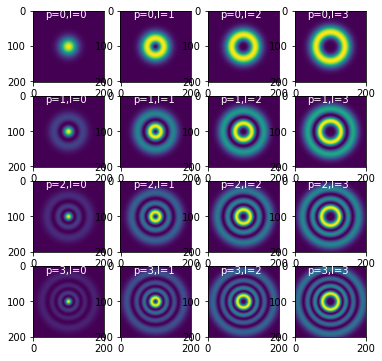

In [109]:
## sample of LG beams
w0 = 1
hw = 3*w0
pts = 201
x0pts, midpt, xx, yy = get_meshgrid(hw,pts)

nrange = 4
fig,axes = plt.subplots(nrange,nrange,figsize=(6,6))
for l in range(nrange):
    for p in range(nrange):
        mode = LG(p,l,w0)
        axes[p][l].imshow(abs(mode(xx,yy))**2)
        axes[p][l].text(35,20,f'p={p},l={l}',color='white')

In [104]:
## define LG_n = LG_p=n,l=1

w0 = 1
LGn = lambda n: LG(n,0,w0)

lg024 = lambda x,y: LGn(0)(x,y) + LGn(2)(x,y) + LGn(4)(x,y)

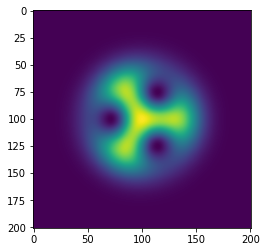

In [105]:
plt.imshow(abs(LG(0,3,w0)(xx,yy)+0.75*LG(0,0,w0)(xx,yy))**2)

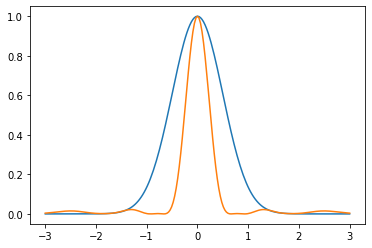

In [114]:
lg024_int = abs(lg024(xx,yy))**2
lg0_int = abs(LGn(0)(xx,yy))**2

w0 = 1
hw = 3*w0
pts = 201
x0pts, midpt, xx, yy = get_meshgrid(hw,pts)

for lg in [lg0_int,lg024_int]:
    plt.plot(x0pts,lg[pts//2+1,:]/np.amax(lg[pts//2+1,:]))

In [117]:
## what is the FT of such a field?
field0 = lg024(xx,yy)

lmbda = 1 # units micron
padding = 50
k = 2*pi/lmbda
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
b=None
f1=1e5
field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,logging=False)

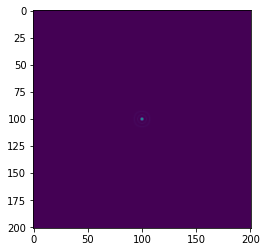

In [119]:
plt.imshow(abs(field1)**2)

(-0.2, 0.2)

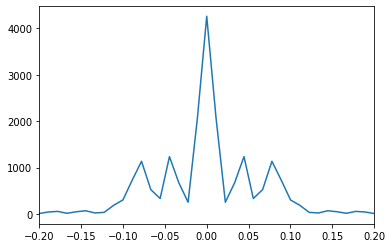

In [230]:
int1 = abs(field1)**2
int1 /= amax(int1)
plt.plot(x1pts/1e6,abs(field1[pts//2+1,:]))
plt.xlim((-0.2,0.2))

(-0.2, 0.2)

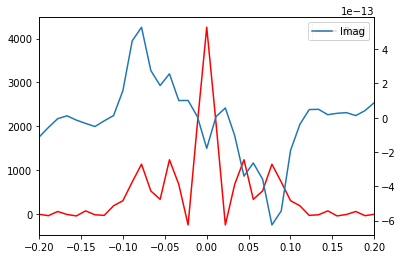

In [134]:
fig,ax = plt.subplots()
ax.plot(x1pts/1e6,real(field1[pts//2+1,:]),label='Real',color='red')
ax2 = ax.twinx()
ax2.plot(x1pts/1e6,imag(field1[pts//2+1,:]),label='Imag')
[a.legend() for a in [ax2,ax]]
ax.set_xlim((-0.2,0.2))

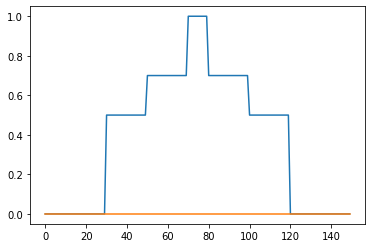

In [236]:
# fft(iffshift())
y0 = 0
y1 = 0.5
y2 = 0.7
y3 = 1
x0 = 30
x1 = 20
x2 = 20
x3 = 10
ydata = x0*[y0]+x1*[y1]+x2*[y2]+x3*[y3]+x2*[y2]+x1*[y1]+x0*[y0]

p0 = 0
p1 = 0
p2 = 0
p3 = 0
pdata = x0*[p0]+x1*[p1]+x2*[p2]+x3*[p3]+x2*[p2]+x1*[p1]+x0*[p0]
xdata = range(len(ydata))
plt.plot(xdata,ydata)
plt.plot(xdata,pdata)

C:\Users\prest\.virtualenvs\fourier-optics-rBKOIr-o\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


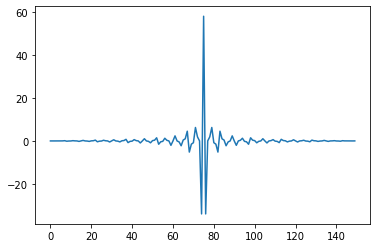

In [237]:
cdata = array(ydata,complex) + 1j*array(pdata,complex)
fdata = fftshift(fft(cdata))
plt.plot(xdata,fdata)
# plt.xlim((50,70))

In [238]:
ffilter = 65*[0] + 20*[1] + 65*[0]
fdata = ffilter*fdata

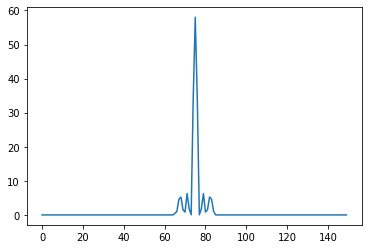

In [239]:
plt.plot(xdata,abs(fdata))

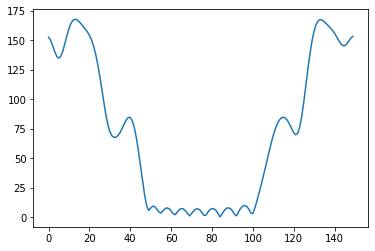

In [223]:
plt.plot(xdata,abs(fftshift(fft(fdata))))

## reproduce Kat's group Fresnel zone plate Fourier filtered beam

In [26]:
# all length units in mm
lmbda = 8.08e-4 #
k = 2*pi/lmbda
a = 0.1 # mask aperture radius
f1 = 100
f2 = f1*0.2
w = 4 # grid width
pts = 1000
xpts = linspace(-w/2, w/2, pts)
ypts = linspace(-w/2, w/2, pts)
xx,yy = meshgrid(xpts,ypts)
rr1 = sqrt(xx**2 + yy**2)
phi = arctan2(yy,xx)

# the input field mask
mask = zeros(rr1.shape)
mask += (rr1 < a).astype(float)

# Fourier plane amplitude mask - fresnel zone style
nzones = 1
jn_0s = jn_zeros(1, 1+2*nzones)
fmask = zeros(rr1.shape)
fmask += rr1 < f1*jn_0s[0]/(k*a) # the central low-pass filter
for n in range(nzones):
    r_inner = f1*jn_0s[2*n+1]/(k*a)
    r_outer = f1*jn_0s[2*n+2]/(k*a)
    # higher spatial frequency notch filter
    fmask += (rr1 > r_inner).astype(float) - (rr1 > r_outer).astype(float)

# Fourier mask - simple aperture
fmaskb = zeros(rr1.shape)
fmaskb += rr1 < f1*jn_0s[0]/(k*a)

In [27]:
r_outer

1.3082794556031594

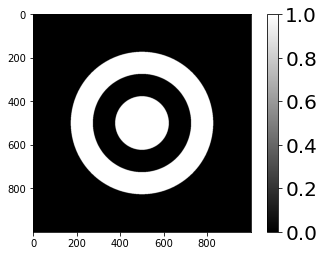

In [28]:
cax = plt.imshow(fmask,cmap='gray')
cax = plt.colorbar(cax)
# plt.xlim((400,600))
# plt.ylim((400,600))
# plt.xticks([])
# plt.yticks([])
cax.ax.tick_params(labelsize=20)
# plt.savefig('fresnel_zone_mask_0ring.svg')

In [17]:
[jn_0s[i] - jn_0s[i+1] for i in range(len(jn_0s)-1)]

[]

In [29]:
# transform to the Fourier plane
field0 = mask
field1,x1pts = lens_xform(f1,field0,b=None,f=f1,k=k,x1pts=xpts,rr=rr,padding=pts//2,masked=False,padval=0,logging=True)
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)

# Fourier plane amplitude mask - fresnel zone style
jn_0s = jn_zeros(1, 1+2*nzones)
fmask = zeros(rr1.shape)
fmask += rr1 < f1*jn_0s[0]/(k*a) # the central low-pass filter
for n in range(nzones):
    r_inner = f1*jn_0s[2*n+1]/(k*a)
    r_outer = f1*jn_0s[2*n+2]/(k*a)
    # higher spatial frequency notch filter
    fmask += (rr1 > r_inner).astype(float) - (rr1 > r_outer).astype(float)

# Fourier mask - simple aperture
fmaskb = zeros(rr1.shape)
fmaskb += rr1 < f1*jn_0s[0]/(k*a)

# fresnel zone mask
field2,x2pts = lens_xform(f2,field1*fmask,b=None,f=f2,k=k,x1pts=x1pts,rr=rr1,padding=pts//2,masked=False,padval=0,logging=True)

# regular mask
field2b,x2pts = lens_xform(f2,field1*fmaskb,b=None,f=f2,k=k,x1pts=x1pts,rr=rr1,padding=pts//2,masked=False,padval=0,logging=True)

f - z2 = 0
calculated field2 in 1.413050651550293 s
f - z2 = 0.0
calculated field2 in 1.425896406173706 s
f - z2 = 0.0
calculated field2 in 1.4412524700164795 s


In [30]:
r_outer,r_inner,f1*jn_0s[0]/(k*a)

(1.3082794556031594, 0.9021847601301376, 0.49274663607166785)

f2/zfresnel=1.0870883454389029


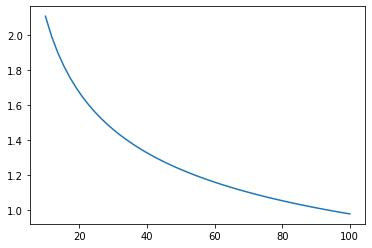

In [343]:
rmax = r_outer
# Fresnel limit
zfresnel = ((k/(8*pi))*(rmax**2)**2)**(1/3)
print(f"f2/zfresnel={f2/zfresnel}")

zfresnel = lambda rmax:((k/(8*pi))*(rmax**2)**2)**(1/3)

rmax = lambda f: f*jn_0s[2*(nzones-1)+2]/(k*a)
fsteps = linspace(10,100,50) # f1
mag = 0.18 # f2/f1
plt.plot(fsteps,[f*mag/zfresnel(rmax(f)) for f in fsteps])

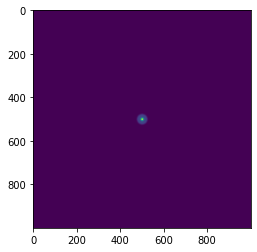

In [31]:
i2xyb = abs(field2b)**2/amax(abs(field2b)**2)
i2xy = abs(field2)**2/amax(abs(field2b)**2)

plt.imshow(i2xy)

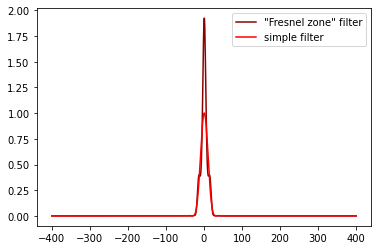

In [32]:
plt.plot(x2pts*1e3,i2xy[500,:],label='"Fresnel zone" filter',color='darkred')
plt.plot(x2pts*1e3,i2xyb[500,:],label='simple filter',color='red')
# plt.xlim((0,20))
plt.legend()

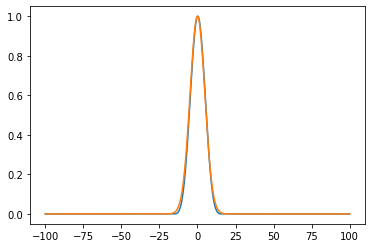

In [337]:
plt.plot(x2pts*1e3,i2xyb[500,:],label='aG simple filter')
w0 = a*0.974*f2/f1
gaussian = lambda x: exp(-2*(x/w0)**2)
plt.plot(x2pts*1e3,gaussian(x2pts))

In [33]:
# axial profile

# fmask was defined and the fourier plane field was
# calculated above

field2_z = []
field2_zb = []

w0 = a*0.974*f2/f1 # the best fit Gaussian waist for standard aG trap
zR = pi*w0**2/lmbda

zpts = linspace(0,2*zR,200)

for dz in zpts:
    # fresnel zone mask
    field2,x2pts = lens_xform(f2+dz,field1*fmask,b=None,f=f2,k=k,x1pts=x1pts,rr=rr1,padding=pts//2,masked=False,padval=0,logging=False)
    field2_z.append(field2[pts//2,pts//2])
    
    # regular mask
    field2b,x2pts = lens_xform(f2+dz,field1*fmaskb,b=None,f=f2,k=k,x1pts=x1pts,rr=rr1,padding=pts//2,masked=False,padval=0,logging=False)
    field2_zb.append(field2b[pts//2,pts//2])

In [377]:
0.4*250*3.8317/(0.1*2*pi/8e-4)

0.4878671963561724

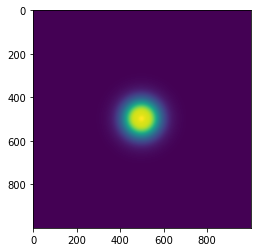

In [378]:
plt.imshow(abs(field2)**2)

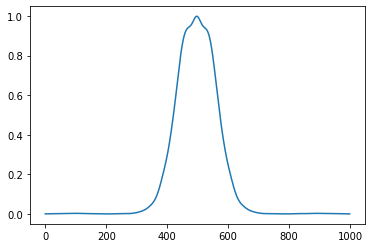

In [379]:
plt.plot((abs(field2)**2/amax(abs(field2)**2))[pts//2,:])

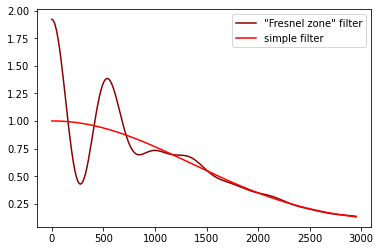

In [34]:
i2zb = abs(array(field2_zb))**2 # simple filter
i2max = max(i2zb)
i2zb /= i2max
i2z = abs(array(field2_z))**2 # Fresnel zone filter
i2z /= i2max

plt.plot(zpts*1e3,i2z,label='"Fresnel zone" filter',color='darkred')
plt.plot(zpts*1e3,i2zb,label='simple filter',color='red')
plt.legend()

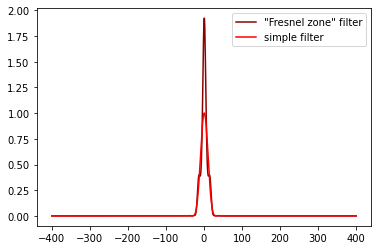

In [35]:
plt.plot(x2pts*1e3,i2xy[500,:],label='"Fresnel zone" filter',color='darkred')
plt.plot(x2pts*1e3,i2xyb[500,:],label='simple filter',color='red')
# plt.xlim((0,20))
plt.legend()

0.1

saved to fresnel_zone_compare1_rho_z_f1_100_f2_20_dimensionless_gaussian_compare.svg


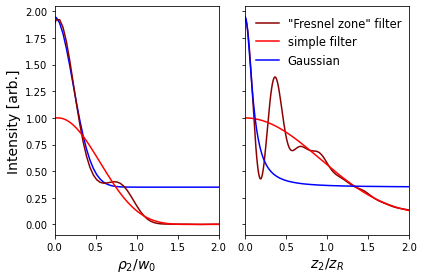

In [63]:
fig,axes = plt.subplots(ncols=2,sharey=True)
fnt = 14
ax,ax2 = axes

w0 = 0.974*a*(f2/f1)
zR = pi*w0**2/lmbda

# ax.plot(x2pts*1e3,i2xy[500,:],label='"Fresnel zone" filter',color='darkred')
# ax.plot(x2pts*1e3,i2xyb[500,:],label='simple filter',color='red')
# ax2.plot(zpts*1e3,i2z,label='"Fresnel zone" filter',color='darkred')
# ax2.plot(zpts*1e3,i2zb,label='simple filter',color='red')
# ax.set_xlim((0,50))
# ax2.set_xlim((0,3000))
# ax.set_ylim((0,3))

# approx Gaussian for the tight trap
ax.plot(x2pts/w0,1.6*exp(-2*x2pts**2/((0.45*w0)**2))+0.35,color='blue')

ax.plot(x2pts/w0,i2xy[500,:],label='"Fresnel zone" filter',color='darkred')
ax.plot(x2pts/w0,i2xyb[500,:],label='simple filter',color='red')

ax2.plot(zpts/zR,i2z,label='"Fresnel zone" filter',color='darkred')
ax2.plot(zpts/zR,i2zb,label='simple filter',color='red')

# approx Gaussian for the tight trap
ax2.plot(zpts/zR,1.6/(1+(zpts/(0.1*zR))**2)+0.35,color='blue',label='Gaussian')

ax.set_xlim((0,2))
ax2.set_xlim((0,2))
# ax.set_ylim((0,3))

# ax.set_ylim((0,2.5))
# ax.set_xlabel(r'$\rho_2$ [$\mathrm{\mu m}$]',fontsize=fnt)
# ax2.set_xlabel(r'$z_2$ [$\mathrm{\mu m}$]',fontsize=fnt)
ax.set_xlabel(r'$\rho_2/w_0$',fontsize=fnt)
ax2.set_xlabel(r'$z_2/z_R$',fontsize=fnt)
ax.set_ylabel('Intensity [arb.]',fontsize=fnt)

# soln_to_csv()

ax2.legend(frameon=False,fontsize=11.5)
fig.tight_layout()

# fname = f'fresnel_zone_compare1_rho_z_f1_{f1}_f2_{f2:.0f}_dimensionless_gaussian_compare.svg'
# plt.savefig(fname)
# print(f'saved to {fname}')

In [59]:
1/0.45

2.2222222222222223

In [319]:
f"{0.2*100:.0f}"

'20'

In [361]:
# fname = f'fresnel_zone_compare2_z_f1_{f1}_f2_{f2:.0f}.csv'
# soln_to_csv(fname,
#             data=[zpts,i2z,i2zb],
#             labels=['z [mm]','Intensity,Fresnel zone filter','Intensity,simple filter'])
# fname = f'fresnel_zone_compare2_rho_f1_{f1}_f2_{f2:.0f}.csv'
# soln_to_csv(fname,
#             data=[x2pts,i2xy[500,:],i2xyb[500,:]],
#             labels=['x [mm]','Intensity,Fresnel zone filter','Intensity,simple filter'])

wrote data to fresnel_zone_compare2_z_f1_100_f2_20.csv
wrote data to fresnel_zone_compare2_rho_f1_100_f2_20.csv


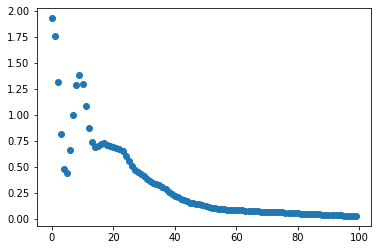

In [254]:
plt.savefigure